In [ ]:
!pip install torch==1.4.0
!pip install pandas==0.25.0
!pip install matplotlib==3.1.0
!pip install numpy==1.16.0

In [3]:
import torch
import torch.nn as nn

import pandas
import matplotlib.pyplot as plt
import random
import numpy

In [4]:
#定义函数，生成近似为1，0，1，0的四个值张量
def generate_real():
    real_data = torch.FloatTensor(
        #取0.8-1.0之间的随机数（近似于1）
        [random.uniform(0.8, 1.0),
         #取0.0-0.2之间的随机数（近似于0）
         random.uniform(0.0, 0.2),
         #取0.8-1.0之间的随机数（近似于1）
         random.uniform(0.8, 1.0),
         #取0.0-0.2之间的随机数（近似于0）
         random.uniform(0.0, 0.2)])
    return real_data

In [5]:
#定义函数，生成特定数量的随机数
def generate_random(size):
    random_data = torch.rand(size)
    return random_data

In [6]:
#构建判别器
class Discriminator(nn.Module):
    
    def __init__(self):
        #初始化网络
        super().__init__()
        #定义神经网络层
        self.model = nn.Sequential(
            nn.Linear(4, 3),
            nn.Sigmoid(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )
        #创建损失函数
        self.loss_function = nn.MSELoss()
        #创建优化器，使用随机梯度下降
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        #计数器
        self.counter = 0
        #进程记录
        self.progress = []
        pass
    
    def forward(self, inputs):
        #直接运行模型
        return self.model(inputs)
    
    def train(self, inputs, targets):
        #计算网络的输出
        outputs = self.forward(inputs)
        #计算损失值
        loss = self.loss_function(outputs, targets)
        #每训练10次计数器加一 
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass
        #梯度归零，反向传播，更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    #建立函数，绘制损失值变化的图形
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass    

In [7]:
D = Discriminator()

for i in range(10000):
    # real data
    D.train(generate_real(), torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random(4), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000


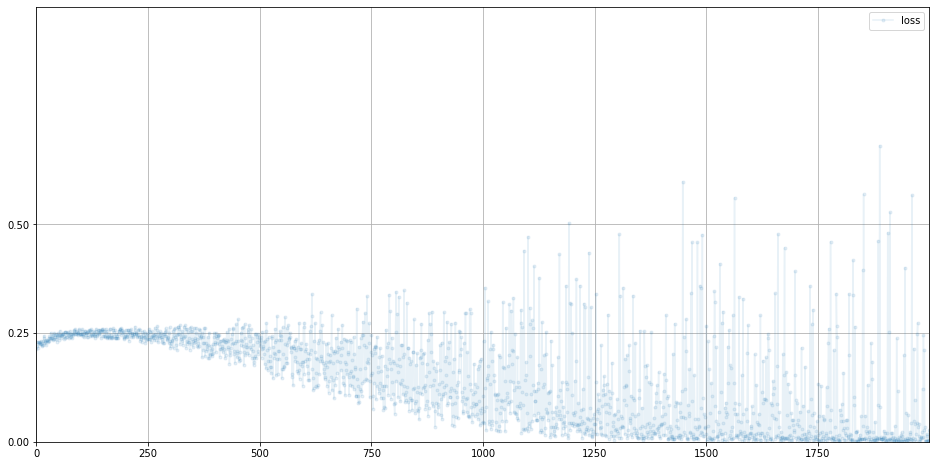

In [8]:
D.plot_progress()

In [9]:
print( D.forward( generate_real() ).item() )
print( D.forward( generate_random(4) ).item() )

0.8135255575180054
0.16949643194675446


In [10]:
class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(1, 3),
            nn.Sigmoid(),
            nn.Linear(3, 4),
            nn.Sigmoid()
        )

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass
    

In [11]:
G = Generator()

G.forward(torch.FloatTensor([0.5]))

tensor([0.3756, 0.4451, 0.6430, 0.6060], grad_fn=<SigmoidBackward>)

In [12]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator()

image_list = []

# train Discriminator and Generator

for i in range(10000):
    
    # train discriminator on true
    D.train(generate_real(), torch.FloatTensor([1.0]))
    
    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))
    
    # train generator
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))
    
    # add image to list every 1000
    if (i % 1000 == 0):
        
        image_list.append( G.forward(torch.FloatTensor([0.5])).detach().numpy() )

    pass

counter =  10000
counter =  20000
CPU times: user 17.8 s, sys: 657 ms, total: 18.5 s
Wall time: 24.1 s


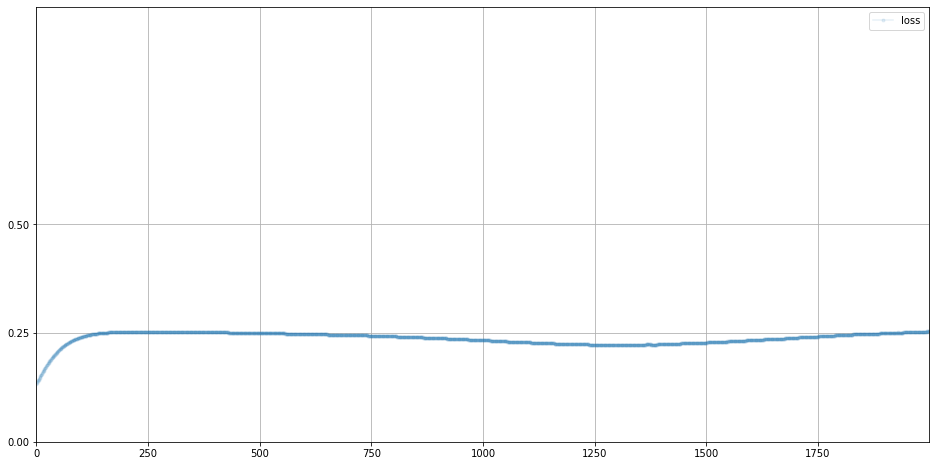

In [13]:
D.plot_progress()

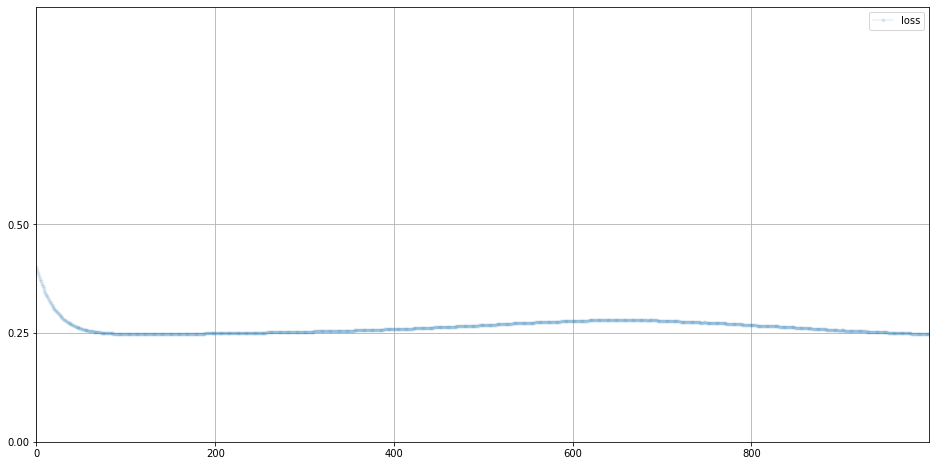

In [14]:
G.plot_progress()

In [15]:
G.forward(torch.FloatTensor([0.5]))

tensor([0.8415, 0.0806, 0.8540, 0.0741], grad_fn=<SigmoidBackward>)

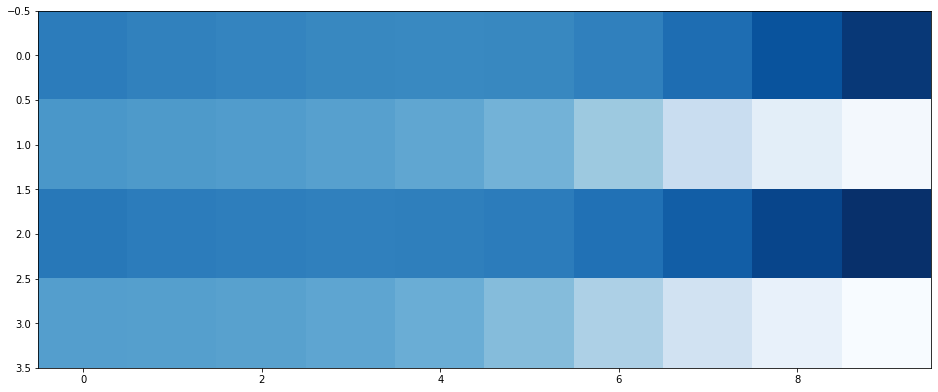

In [16]:
plt.figure(figsize = (16,8))

plt.imshow(numpy.array(image_list).T, interpolation='none', cmap='Blues')

以上图像非常清晰地显示了生成器是如何随着训练时间而进步的。一开始，生成器输出的规律很模糊（颜色深浅混乱），在训练进行到一半时，生成器便能生成有点符合1-0-1-0格式规律的值了（颜色开始呈现出一行深一行浅）。在之后的训练过程中，该规律越来越清晰了。